In [92]:
from os.path import dirname, join as pjoin
# from pathlib import Path
import pandas as pd
import seaborn as sns
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np


In [93]:
RATS_ID = ['0804', '1304', '1810', '3105']
EXPERIMENTS = ['Filtered', 'Raw','LR-TGV', 'MP-PCA']
REGIONS = ['Hippocampus', 'Striatum']
MET_NAMES = [
    "Mac", "Cr", "PCr", "Ins", "NAA", "Tau", "PCho", "GPC", "Glu", "Gln", "Ala",
    "Asc", "Asp", "GABA", "Glc", "GSH", "Lac", "NAAG", "PE", "NAA+NAAG", "Glu+Gln", "CPG +PCho", "Cr+PCr"] 

MET_IGNORED = ["Ala", "Asp", "Cr"] # Removing some metabolites we are not interested into

COLUMN_NAMES=['rat_id','processing','region','metabolite','mean_conc','std_conc', 'mean_diff_vs_filtered', 'mean_diff_MP_vs_LR']

df = pd.DataFrame(columns=COLUMN_NAMES)
# Set a MultiIndex on the columns for faster access
df.set_index(['rat_id', 'processing', 'region', 'metabolite'], inplace=True)
data_path = 'data/Rat_'

for experiment in EXPERIMENTS:
    for rat_id in RATS_ID:
        file_path = os.path.join(data_path + rat_id, experiment)
        for region in REGIONS:
            mat_fname = pjoin(file_path, region + '_L+R.mat')

            # Loading the .mat
            mat_contents = sio.loadmat(mat_fname)
            met_conc = mat_contents['results']['met_conc'][0,0]
            

            # Accessing the relative mean and std columns
            mean_conc_rel = met_conc['mean_conc_rel'][0]
            std_conc_rel = met_conc['std_conc_rel'][0]

            # Looping through the metabolites
            for i, met_name in enumerate(MET_NAMES):
                if met_name in MET_IGNORED:
                    continue # Skip metabolites that we wish to ignore
                
                met_mean = mean_conc_rel[i][0][0]
                met_std = std_conc_rel[i][0][0]

                # Adding the difference w.r.t. the Filtered data used as Golden Standard
                if experiment != 'Filtered':
                    # Accessing the correct Filtered data
                    relevant_filtered_row = df.loc[(rat_id, 'Filtered', region, met_name)]
                   
                    # Computing the difference
                    mean_diff_vs_filtered = (met_mean - relevant_filtered_row['mean_conc'])/(relevant_filtered_row['mean_conc']) if relevant_filtered_row['mean_conc'] != 0 else 0

                    # Adding the difference compared to the LR-TGV processing for the MP-PCA technique
                    if experiment == 'MP-PCA':
                        # Accessing the correct LR-TGV
                        relevant_LR_row = df.loc[(rat_id, 'LR-TGV', region, met_name)]
                    
                        # Computing the inconcistency w.r.t LR-TGV => Absolute value
                        mean_diff_MP_vs_LR = np.abs(met_mean - relevant_LR_row['mean_conc'])/(relevant_LR_row['mean_conc']) if relevant_LR_row['mean_conc'] != 0 else 0

                    else:
                        mean_diff_MP_vs_LR = np.nan
                else:
                    mean_diff_vs_filtered = np.nan
                    mean_diff_MP_vs_LR = np.nan

                # Updating the dataframe
                new_row = pd.DataFrame([[
                    rat_id,
                    experiment,
                    region,
                    met_name,
                    met_mean,
                    met_std,
                    mean_diff_vs_filtered,
                    mean_diff_MP_vs_LR,
                ]], columns=COLUMN_NAMES)
                
                # Set the MultiIndex for this new row
                new_row.set_index(['rat_id', 'processing', 'region', 'metabolite'], inplace=True)

                # Concatenate the new row to df
                df = pd.concat([df, new_row])

                # Sort the index to ensure it is lexicographically sorted
                df.sort_index(inplace=True)
# Resetting the Multi Index
df = df.reset_index()


/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_42812/447969423.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])
/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_42812/447969423.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])
/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_42812/447969423.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In 

In [94]:
# df[(df['processing'] == 'Filtered') & (df['mean_conc'] < 2) & (df['rat_id'] == '3105')]
df.sample(25)

,rat_id,processing,region,metabolite,mean_conc,std_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
382,1810,LR-TGV,Striatum,Cr+PCr,8.000000,0.000000,0.000000,NaN
386,1810,LR-TGV,Striatum,Glc,1.879500,0.121818,0.070940,NaN
601,3105,Raw,Hippocampus,CPG +PCho,12.411368,2.116686,10.148870,NaN
73,0804,LR-TGV,Striatum,NAA,8.271212,1.254647,-0.125912,NaN
3,0804,Filtered,Hippocampus,GABA,1.366500,0.182751,NaN,NaN
300,1304,Raw,Striatum,Asc,9.323353,2.401614,0.648038,NaN
448,1810,Raw,Hippocampus,Glu,10.967633,1.630345,-0.148018,NaN
226,1304,LR-TGV,Striatum,Glc,3.816000,0.000000,1.147440,NaN
238,1304,LR-TGV,Striatum,PE,2.977375,0.523721,0.000000,NaN
64,0804,LR-TGV,Striatum,GPC,1.050400,0.160343,-0.249893,NaN


## Finding Metabolites with 0 concentration

In [95]:
print(df[(df['processing'] == 'Filtered') & (df['mean_conc'] == 0)].shape[0], 'Entries for The Filtered Data')
df[(df['processing'] == 'Filtered') & (df['mean_conc'] == 0)]

11 Entries for The Filtered Data


,rat_id,processing,region,metabolite,mean_conc,std_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
4,0804,Filtered,Hippocampus,GPC,0.0,0.0,NaN,NaN
6,0804,Filtered,Hippocampus,Glc,0.0,0.0,NaN,NaN
18,0804,Filtered,Hippocampus,PE,0.0,0.0,NaN,NaN
166,1304,Filtered,Hippocampus,Glc,0.0,0.0,NaN,NaN
198,1304,Filtered,Striatum,PE,0.0,0.0,NaN,NaN
324,1810,Filtered,Hippocampus,GPC,0.0,0.0,NaN,NaN
326,1810,Filtered,Hippocampus,Glc,0.0,0.0,NaN,NaN
344,1810,Filtered,Striatum,GPC,0.0,0.0,NaN,NaN
358,1810,Filtered,Striatum,PE,0.0,0.0,NaN,NaN
504,3105,Filtered,Striatum,GPC,0.0,0.0,NaN,NaN


In [96]:
print(df[(df['processing'] == 'LR-TGV') & (df['mean_conc'] == 0)].shape[0], 'Entries for The LR-TGV Data')
df[(df['processing'] == 'LR-TGV') & (df['mean_conc'] == 0)]

15 Entries for The LR-TGV Data


,rat_id,processing,region,metabolite,mean_conc,std_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
46,0804,LR-TGV,Hippocampus,Glc,0.0,0.0,0.0,NaN
51,0804,LR-TGV,Hippocampus,Lac,0.0,0.0,-1.0,NaN
58,0804,LR-TGV,Hippocampus,PE,0.0,0.0,0.0,NaN
66,0804,LR-TGV,Striatum,Glc,0.0,0.0,-1.0,NaN
71,0804,LR-TGV,Striatum,Lac,0.0,0.0,-1.0,NaN
75,0804,LR-TGV,Striatum,NAAG,0.0,0.0,-1.0,NaN
206,1304,LR-TGV,Hippocampus,Glc,0.0,0.0,0.0,NaN
211,1304,LR-TGV,Hippocampus,Lac,0.0,0.0,-1.0,NaN
215,1304,LR-TGV,Hippocampus,NAAG,0.0,0.0,-1.0,NaN
231,1304,LR-TGV,Striatum,Lac,0.0,0.0,-1.0,NaN


## Defining the variables of comparison

## Plot A) Plotting the difference of concentration compared to filtered data for each processing
Aggregating by processing, averaging over the 4 rats the difference compared to filtered data for each metabolite

## Plotting the difference of concentration compared to filtered for each processing

In [97]:
""" Hippocampus """
# Hippocampus: LR-TGV vs Filtered (Average over all Rats for each metabolite)
LR_Hipp_vs_Filtered_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
LR_Hipp_vs_Filtered_std = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()
#all_LR_Hipp_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')]['mean_diff'].reset_index(drop=True)
#all_LR_Hipp_std = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')]['std_diff'].reset_index(drop=True) # Not sure this std difference makes sense to use

# Hippocampus: MP-PCA vs Filtered (Average over all Rats for each metabolite)
MP_Hipp_vs_Filtered_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
MP_Hipp_vs_Filtered_std = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

# Hippocampus: Raw vs Filtered (Average over all Rats for each metabolite)
Raw_Hipp_vs_Filtered_mean = df[(df['processing']=='Raw') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
Raw_Hipp_vs_Filtered_std = df[(df['processing']=='Raw') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

""" Striatum """
# Striatum: LR-TGV vs Filtered (Average over all Rats for each metabolite)
LR_Stri_vs_Filtered_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
LR_Stri_vs_Filtered_std = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Striatum: MP-PCA vs Filtered (Average over all Rats for each metabolite)
MP_Stri_vs_Filtered_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
MP_Stri_vs_Filtered_std = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Striatum: Raw vs Filtered (Average over all Rats for each metabolite)
Raw_Stri_vs_Filtered_mean = df[(df['processing']=='Raw') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
Raw_Stri_vs_Filtered_std = df[(df['processing']=='Raw') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

In [98]:
colors = sns.color_palette('cool', 3)
colors

[(0.25098039215686274, 0.7490196078431373, 1.0),
 (0.5019607843137255, 0.4980392156862745, 1.0),
 (0.7529411764705882, 0.24705882352941178, 1.0)]

### 1.a) Hippocampus

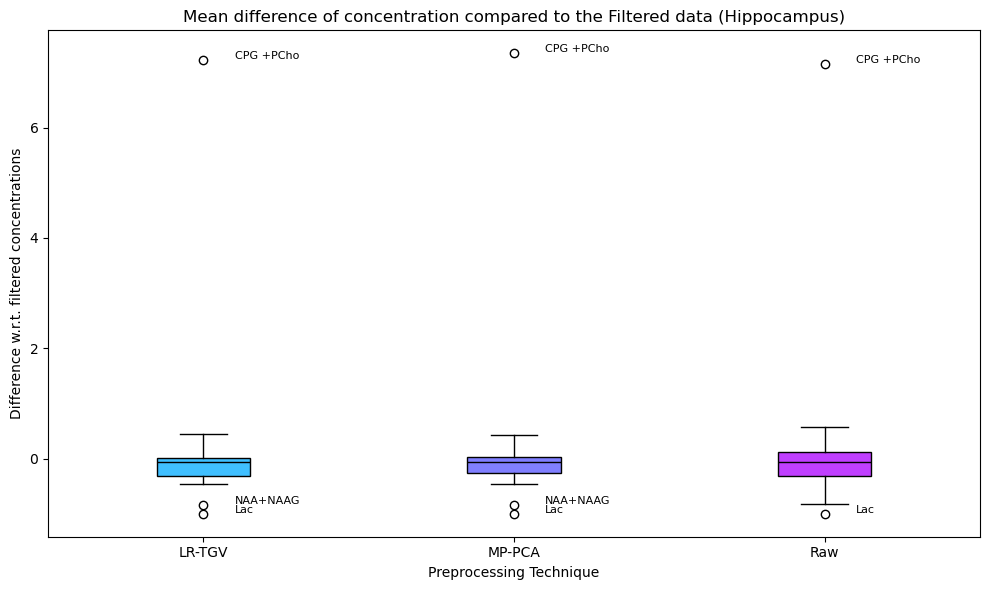

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = ["LR-TGV", "MP-PCA", "Raw"]
y_data = [LR_Hipp_vs_Filtered_mean, MP_Hipp_vs_Filtered_mean, Raw_Hipp_vs_Filtered_mean]

# Create the boxplot
bplot = ax.boxplot(x=y_data, vert=True, patch_artist=True, tick_labels=labels)

plt.title('Mean difference of concentration compared to the Filtered data (Hippocampus)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Difference w.r.t. filtered concentrations')

# Set the facecolor for each box
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Define the offset for labels
x_offset = 0.1  # Horizontal offset
y_offset = 0.02  # Vertical offset (can be negative or positive)

# Label the outliers
for i, (series, fliers) in enumerate(zip(y_data, bplot['fliers'])):
    y_outliers = fliers.get_ydata()  # Get the y-coordinates of the outliers
    for j, y in enumerate(y_outliers):
        index = series[series == y].index  # Get the index of the outlier
        if not index.empty:  # Check if an index was found
            # Adjust the x and y positions with the offsets
            ax.text(
                i + 1 + x_offset,  # Shift horizontally
                y + y_offset,      # Shift vertically
                f'{index[0]}', 
                ha='left', fontsize=8, color='black'
            )
# Change the color of the median lines
for median in bplot['medians']:
    median.set_color('black')
plt.tight_layout()
plt.show()


### 1.b) Striatum

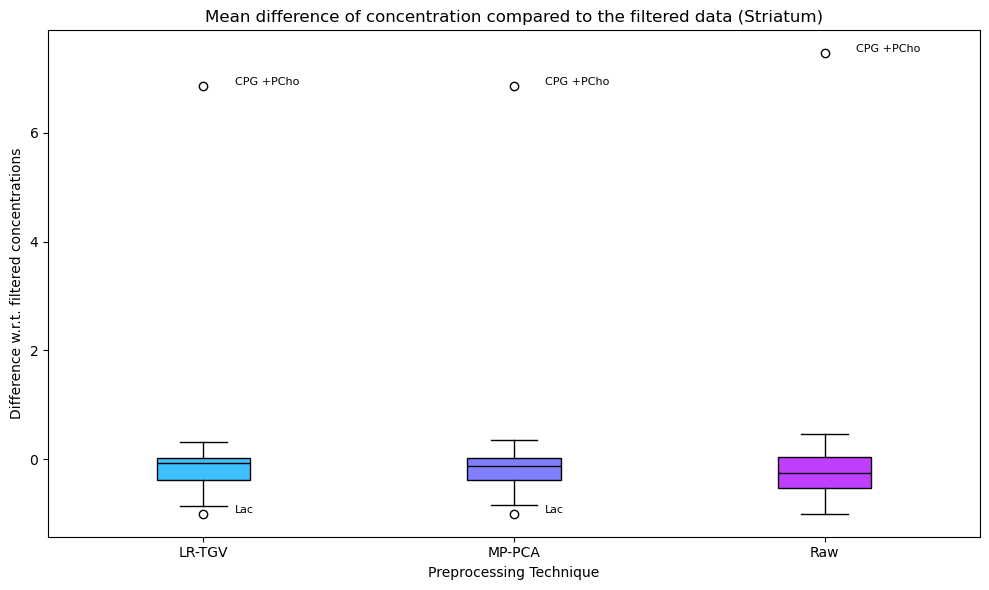

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = ["LR-TGV", "MP-PCA", "Raw"]
y_data = [LR_Stri_vs_Filtered_mean, MP_Stri_vs_Filtered_mean, Raw_Stri_vs_Filtered_mean]

# Create the boxplot
bplot = ax.boxplot(x=y_data, vert=True, patch_artist=True, tick_labels=labels)

plt.title('Mean difference of concentration compared to the filtered data (Striatum)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Difference w.r.t. filtered concentrations')

# Set the facecolor for each box
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Define the offset for labels
x_offset = 0.1  # Horizontal offset
y_offset = 0.02  # Vertical offset (can be negative or positive)

# Label the outliers
for i, (series, fliers) in enumerate(zip(y_data, bplot['fliers'])):
    y_outliers = fliers.get_ydata()  # Get the y-coordinates of the outliers
    for j, y in enumerate(y_outliers):
        index = series[series == y].index  # Get the index of the outlier
        if not index.empty:  # Check if an index was found
            # Adjust the x and y positions with the offsets
            ax.text(
                i + 1 + x_offset,  # Shift horizontally
                y + y_offset,      # Shift vertically
                f'{index[0]}', 
                ha='left', fontsize=8, color='black'
            )
# Change the color of the median lines
for median in bplot['medians']:
    median.set_color('black')

#sns.despine()
plt.tight_layout()
plt.show()


## Plot B) Difference of concentration for each metabolite across the processing
(Averaged over the 4 rats)

### B.1) Hippocampus

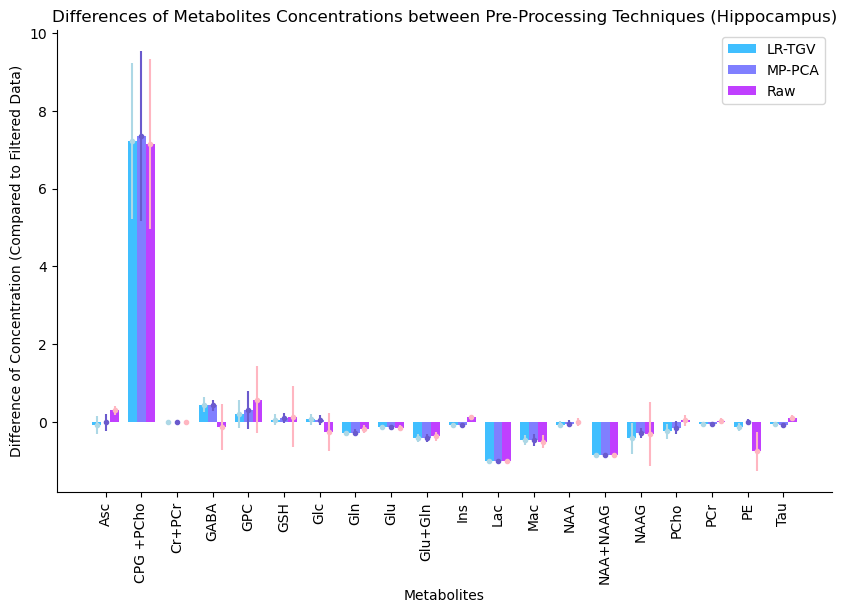

In [101]:
X_axis = np.arange(len(LR_Hipp_vs_Filtered_mean)) 

fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.25

#Barplots for each category
ax.bar(X_axis - bar_width, LR_Hipp_vs_Filtered_mean.values, bar_width, color=colors[0], label='LR-TGV')
ax.errorbar(X_axis - bar_width, LR_Hipp_vs_Filtered_mean, yerr=LR_Hipp_vs_Filtered_std, fmt='.', color="lightblue")

ax.bar(X_axis, MP_Hipp_vs_Filtered_mean.values, bar_width, color=colors[1], label='MP-PCA')
ax.errorbar(X_axis, MP_Hipp_vs_Filtered_mean, yerr=MP_Hipp_vs_Filtered_std, fmt='.', color="slateblue")

# Third category
ax.bar(X_axis + bar_width, Raw_Hipp_vs_Filtered_mean.values, bar_width, color=colors[2], label='Raw')
ax.errorbar(X_axis + bar_width, Raw_Hipp_vs_Filtered_mean, yerr=Raw_Hipp_vs_Filtered_std, fmt='.', color="lightpink")

# Set x-axis ticks and labels
ax.set_xticks(X_axis)
ax.set_xticklabels(LR_Hipp_vs_Filtered_mean.index)
plt.xticks(rotation=90)

# Titles and labels
ax.set_title("Differences of Metabolites Concentrations between Pre-Processing Techniques (Hippocampus)")
plt.xlabel("Metabolites")
plt.ylabel("Difference of Concentration (Compared to Filtered Data)")

# Legend and styling
plt.legend()
sns.despine()
plt.show()


### B.2) Striatum

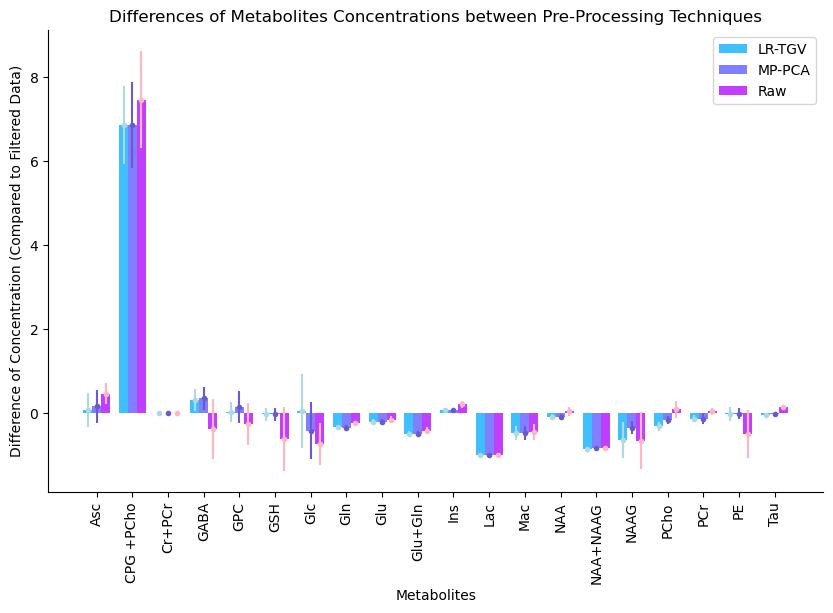

In [102]:
X_axis = np.arange(len(LR_Stri_vs_Filtered_mean))  # Shared x-axis for all categories

fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.25

# Barplots for each category
ax.bar(X_axis - bar_width, LR_Stri_vs_Filtered_mean.values, bar_width, color=colors[0], label='LR-TGV')
ax.errorbar(X_axis - bar_width, LR_Stri_vs_Filtered_mean, yerr=LR_Stri_vs_Filtered_std, fmt='.', color="lightblue")

ax.bar(X_axis, MP_Stri_vs_Filtered_mean.values, bar_width, color=colors[1], label='MP-PCA')
ax.errorbar(X_axis, MP_Stri_vs_Filtered_mean, yerr=MP_Stri_vs_Filtered_std, fmt='.', color="slateblue")

# Third category
ax.bar(X_axis + bar_width, Raw_Stri_vs_Filtered_mean.values, bar_width, color=colors[2], label='Raw')
ax.errorbar(X_axis + bar_width, Raw_Stri_vs_Filtered_mean, yerr=Raw_Stri_vs_Filtered_std, fmt='.', color="lightpink")

# Set x-axis ticks and labels
ax.set_xticks(X_axis)
ax.set_xticklabels(LR_Stri_vs_Filtered_mean.index)
plt.xticks(rotation=90)

# Titles and labels
ax.set_title("Differences of Metabolites Concentrations between Pre-Processing Techniques")
plt.xlabel("Metabolites")
plt.ylabel("Difference of Concentration (Compared to Filtered Data)")

# Legend and styling
plt.legend()
sns.despine()
plt.show()


## Plot C) Differences of concentration between the processing technique vs concentration of the metabolites

In [103]:
# LR-TGV vs MP-PCA
MP_vs_LR_Hipp_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_MP_vs_LR']]
MP_vs_LR_Stri_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_MP_vs_LR']]
mean_diff_vs_filtered
# LR-TGV vs Filter
Filtered_vs_LR_Hipp_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_vs_filtered']]
Filtered_vs_LR_Stri_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_vs_filtered']]

# MP-PCA vs Filter
Filtered_vs_MP_Hipp_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_vs_filtered']]
Filtered_vs_MP_Stri_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_vs_filtered']]


### C.1) Hippocampus

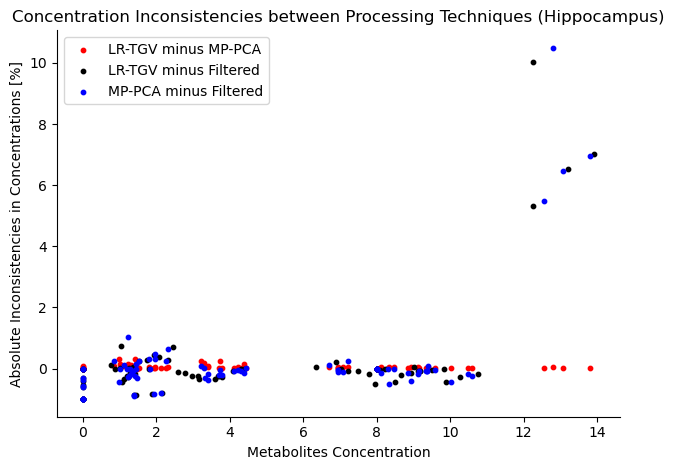

In [104]:
fig, ax = plt.subplots()
plt.scatter(MP_vs_LR_Hipp_mean.mean_conc, MP_vs_LR_Hipp_mean.mean_diff_MP_vs_LR, color = 'r', s=10, label = 'LR-TGV minus MP-PCA')
plt.scatter(Filtered_vs_LR_Hipp_mean.mean_conc, Filtered_vs_LR_Hipp_mean.mean_diff_vs_filtered, color = 'black', s=10, label = 'LR-TGV minus Filtered')
plt.scatter(Filtered_vs_MP_Hipp_mean.mean_conc, Filtered_vs_MP_Hipp_mean.mean_diff_vs_filtered, color = 'blue', s=10, label = 'MP-PCA minus Filtered')

ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_xlabel("Metabolites Concentration")
plt.title("Concentration Inconsistencies between Processing Techniques (Hippocampus)")
plt.legend()
sns.despine()
plt.tight_layout()

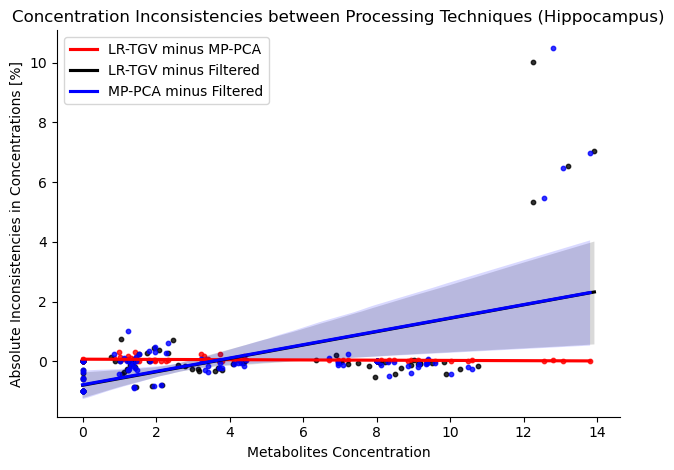

In [105]:
# Create the figure and axes
fig, ax = plt.subplots()

# Plot scatter and regression lines for each comparison
sns.regplot(
    x=MP_vs_LR_Hipp_mean.mean_conc,
    y=MP_vs_LR_Hipp_mean.mean_diff_MP_vs_LR,
    scatter_kws={'color': 'r', 's': 10},
    line_kws={'label': 'LR-TGV minus MP-PCA', 'color': 'r'},
    ci=95,  # Confidence interval
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_LR_Hipp_mean.mean_conc,
    y=Filtered_vs_LR_Hipp_mean.mean_diff_vs_filtered,
    scatter_kws={'color': 'black', 's': 10},
    line_kws={'label': 'LR-TGV minus Filtered', 'color': 'black'},
    ci=95,
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_MP_Hipp_mean.mean_conc,
    y=Filtered_vs_MP_Hipp_mean.mean_diff_vs_filtered,
    scatter_kws={'color': 'blue', 's': 10},
    line_kws={'label': 'MP-PCA minus Filtered', 'color': 'blue'},
    ci=95,
    ax=ax,
)

# Add labels, title, and legend
ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_xlabel("Metabolites Concentration")
ax.set_title("Concentration Inconsistencies between Processing Techniques (Hippocampus)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

### C.2) Striatum

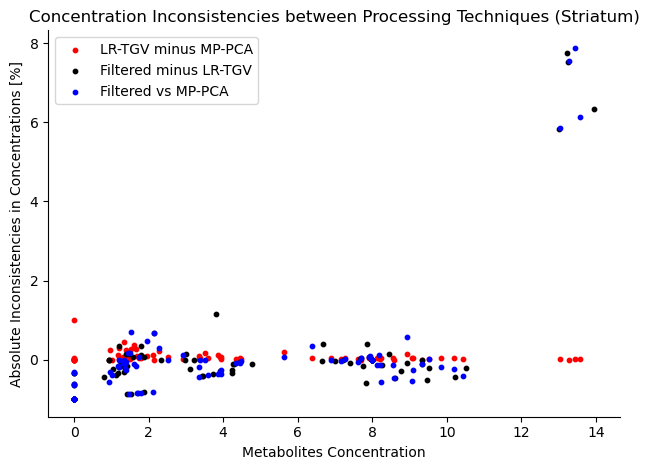

In [106]:
fig, ax = plt.subplots()
plt.scatter(MP_vs_LR_Stri_mean.mean_conc, MP_vs_LR_Stri_mean.mean_diff_MP_vs_LR, color = 'r', s=10, label = 'LR-TGV minus MP-PCA')
plt.scatter(Filtered_vs_LR_Stri_mean.mean_conc, Filtered_vs_LR_Stri_mean.mean_diff_vs_filtered, color = 'black', s=10, label = 'Filtered minus LR-TGV')
plt.scatter(Filtered_vs_MP_Stri_mean.mean_conc, Filtered_vs_MP_Stri_mean.mean_diff_vs_filtered, color = 'blue', s=10, label = 'Filtered vs MP-PCA')

ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_xlabel("Metabolites Concentration")
plt.title("Concentration Inconsistencies between Processing Techniques (Striatum)")
plt.legend()
sns.despine()
plt.tight_layout()

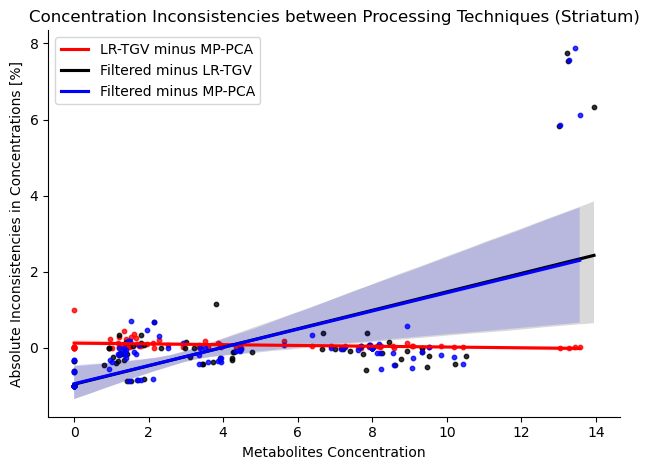

In [107]:
# Create the figure and axes
fig, ax = plt.subplots()

# Plot scatter and regression lines for each comparison
sns.regplot(
    x=MP_vs_LR_Stri_mean.mean_conc,
    y=MP_vs_LR_Stri_mean.mean_diff_MP_vs_LR,
    scatter_kws={'color': 'r', 's': 10},
    line_kws={'label': 'LR-TGV minus MP-PCA', 'color': 'r'},
    ci=95,  # Confidence interval
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_LR_Stri_mean.mean_conc,
    y=Filtered_vs_LR_Stri_mean.mean_diff_vs_filtered,
    scatter_kws={'color': 'black', 's': 10},
    line_kws={'label': 'Filtered minus LR-TGV', 'color': 'black'},
    ci=95,
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_MP_Stri_mean.mean_conc,
    y=Filtered_vs_MP_Stri_mean.mean_diff_vs_filtered,
    scatter_kws={'color': 'blue', 's': 10},
    line_kws={'label': 'Filtered minus MP-PCA', 'color': 'blue'},
    ci=95,
    ax=ax,
)

# Add labels, title, and legend
ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_xlabel("Metabolites Concentration")
ax.set_title("Concentration Inconsistencies between Processing Techniques (Striatum)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()
